# Mixture of 3 Normals with NGBoost

**Problem**: Regression on real-valued, potentially multimodal data —
when the outcome has multiple "regimes" or clusters that span negative
and positive values.

**When to use**:
- Temperature anomaly modeling: cold / normal / warm regimes
- Financial returns: bear market / flat / bull market periods
- Sensor calibration: offsets that cluster around different values
- Any real-valued outcome where a single unimodal distribution is a poor fit

**How it works**: 8 parameters — 3 component means (unbounded), 3 component
std devs (log-link, positive), and 2 mixture weight logits (3rd weight is
determined by the constraint that weights sum to 1). The factory auto-derives
all 8 gradients and the 8x8 Fisher Information from the symbolic mixture PDF.

**Key difference from Mixture-of-LogNormals**: `y` is unbounded (no positivity
constraint), so the factory skips the `Y > 0` clamp that is needed for
log-domain distributions. This is detected automatically from the symbolic
expression — no manual configuration needed.

In [2]:
import numpy as np
import sympy as sp
import scipy.stats
from sklearn.model_selection import train_test_split

from ngboost import NGBRegressor
from ngboost.distns.sympy_utils import make_distribution

## 1. Define the mixture PDF symbolically

8 parameters:
- `mu1, mu2, mu3` — component means (identity link, unbounded)
- `sigma1, sigma2, sigma3` — component std devs (log link, positive)
- `logit_w1, logit_w2` — mixture weights via softmax (3rd logit fixed at 0)

Note: `y` is declared without `positive=True` — this tells the factory that
negative observations are valid.

In [3]:
# Symbols — note y is unbounded (no positive=True)
mu1, mu2, mu3 = sp.symbols("mu1 mu2 mu3")
sigma1, sigma2, sigma3 = sp.symbols("sigma1 sigma2 sigma3", positive=True)
logit_w1, logit_w2 = sp.symbols("logit_w1 logit_w2")
y = sp.symbols("y")

# Mixture weights via softmax (3rd logit fixed at 0)
e1, e2 = sp.exp(logit_w1), sp.exp(logit_w2)
Z = e1 + e2 + 1
w1, w2, w3 = e1 / Z, e2 / Z, 1 / Z


def normal_pdf(y, mu, sigma):
    return sp.exp(-((y - mu) ** 2) / (2 * sigma**2)) / (
        sigma * sp.sqrt(2 * sp.pi)
    )


# Mixture PDF and score
mixture_pdf = (
    w1 * normal_pdf(y, mu1, sigma1)
    + w2 * normal_pdf(y, mu2, sigma2)
    + w3 * normal_pdf(y, mu3, sigma3)
)
score_expr = -sp.log(mixture_pdf)

print("Mixture PDF defined with 8 parameters.")
print(f"  Components: 3 Normals (unbounded y)")
print(f"  Weight params: logit_w1, logit_w2 (softmax with 3rd fixed at 0)")

Mixture PDF defined with 8 parameters.
  Components: 3 Normals (unbounded y)
  Weight params: logit_w1, logit_w2 (softmax with 3rd fixed at 0)


## 2. Custom fit and sample functions

Mixtures need domain-aware initialization — the auto MLE fit (starting from
zeros) is impractical with 8 parameters and a multimodal likelihood.
Sampling also requires knowing the mixture structure (pick component, then sample).

In [4]:
def fit_mixture(Y):
    """Initialize parameters from data using quantile splitting."""
    sorted_Y = np.sort(Y)
    n = len(sorted_Y)

    g1 = sorted_Y[: n // 3]
    g2 = sorted_Y[n // 3 : 2 * n // 3]
    g3 = sorted_Y[2 * n // 3 :]

    m1, m2, m3 = np.mean(g1), np.mean(g2), np.mean(g3)
    s1, s2, s3 = max(np.std(g1), 0.1), max(np.std(g2), 0.1), max(np.std(g3), 0.1)

    # [mu1, mu2, mu3, log(sigma1), log(sigma2), log(sigma3), logit_w1, logit_w2]
    return np.array([m1, m2, m3, np.log(s1), np.log(s2), np.log(s3), 0.0, 0.0])


def sample_mixture(self, m):
    """Sample by first choosing a component, then sampling from that Normal."""
    e1 = np.exp(np.atleast_1d(self.logit_w1))
    e2 = np.exp(np.atleast_1d(self.logit_w2))
    Z = e1 + e2 + 1

    mus = [np.atleast_1d(self.mu1), np.atleast_1d(self.mu2), np.atleast_1d(self.mu3)]
    sigs = [np.atleast_1d(self.sigma1), np.atleast_1d(self.sigma2), np.atleast_1d(self.sigma3)]
    weights = np.stack([e1 / Z, e2 / Z, 1 / Z], axis=-1)  # (n_obs, 3)

    n_obs = len(mus[0])
    results = np.zeros((m, n_obs))
    for s in range(m):
        u = np.random.random(n_obs)
        c1 = u < weights[:, 0]
        c2 = (~c1) & (u < weights[:, 0] + weights[:, 1])
        c3 = ~(c1 | c2)
        for mask, mu_k, sig_k in zip([c1, c2, c3], mus, sigs):
            if mask.any():
                results[s, mask] = np.random.normal(mu_k[mask], sig_k[mask])
    return results


print("Custom fit and sample functions defined.")

Custom fit and sample functions defined.


## 3. Create the distribution

In [5]:
MixtureN3 = make_distribution(
    params=[
        (mu1, False),
        (mu2, False),
        (mu3, False),
        (sigma1, True),
        (sigma2, True),
        (sigma3, True),
        (logit_w1, False),
        (logit_w2, False),
    ],
    y=y,
    score_expr=score_expr,
    fit_fn=fit_mixture,
    sample_fn=sample_mixture,
    name="MixtureN3",
)

print(f"Created: {MixtureN3}")
print(f"  n_params: {MixtureN3.n_params}")
print(f"  mean() uses sampling fallback (no scipy class)")

Created: <class 'ngboost.distns.sympy_utils.MixtureN3'>
  n_params: 8
  mean() uses sampling fallback (no scipy class)


## 4. Generate synthetic multimodal data with negative values

Three well-separated components centered at **-5**, **0**, and **+5**.
Component means shift with features, so the model has something to learn.

In [6]:
np.random.seed(42)
n_samples = 1500
n_features = 5

X = np.random.randn(n_samples, n_features)

# True component means — note mu1 is strongly negative
true_mu1 = -5.0 + 0.8 * X[:, 0]   # centered around -5
true_mu2 =  0.5 + 1.0 * X[:, 1]   # centered around 0.5
true_mu3 =  5.0 + 0.6 * X[:, 2]   # centered around +5

# Fixed sigmas and weights
true_sigma = [0.8, 1.0, 0.9]
true_weights = [0.35, 0.35, 0.30]

# Sample from the mixture
components = np.random.choice(3, size=n_samples, p=true_weights)
Y = np.zeros(n_samples)
for i in range(n_samples):
    k = components[i]
    mu_k = [true_mu1[i], true_mu2[i], true_mu3[i]][k]
    Y[i] = np.random.normal(mu_k, true_sigma[k])

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

print(f"Y range: [{Y.min():.2f}, {Y.max():.2f}]")
print(f"Y mean:  {Y.mean():.2f}")
print(f"Negative Y values: {(Y < 0).sum()} / {n_samples} ({100*(Y < 0).mean():.0f}%)")
print(f"Train: {len(Y_train)}, Test: {len(Y_test)}")

Y range: [-8.49, 7.63]
Y mean:  -0.03
Negative Y values: 686 / 1500 (46%)
Train: 1200, Test: 300


## 5. Train NGBoost

In [7]:
from sklearn.tree import DecisionTreeRegressor

tree_learner = DecisionTreeRegressor(
    criterion="friedman_mse",
    min_samples_split=10,
    min_samples_leaf=3,
    max_depth=3,
    random_state=None,
)

ngb = NGBRegressor(
    Dist=MixtureN3,
    Base=tree_learner,
    n_estimators=1000,
    learning_rate=0.01,
    verbose=False,
    random_state=42,
)
ngb.fit(X_train, Y_train)
print("Training complete.")

Training complete.


## 6. Predictions and parameters

In [8]:
Y_pred = ngb.predict(X_test)
dists = ngb.pred_dist(X_test)

# Compute mixture weights for first 5 test samples
e1 = np.exp(dists.logit_w1[:5])
e2 = np.exp(dists.logit_w2[:5])
Z = e1 + e2 + 1

print("Component parameters (first 5 test samples):")
print(f"  mu1:    {dists.mu1[:5].round(3)}")
print(f"  mu2:    {dists.mu2[:5].round(3)}")
print(f"  mu3:    {dists.mu3[:5].round(3)}")
print(f"  sigma1: {dists.sigma1[:5].round(3)}")
print(f"  sigma2: {dists.sigma2[:5].round(3)}")
print(f"  sigma3: {dists.sigma3[:5].round(3)}")
print(f"\nMixture weights (first 5):")
print(f"  w1: {(e1 / Z).round(3)}")
print(f"  w2: {(e2 / Z).round(3)}")
print(f"  w3: {(1 / Z).round(3)}")
print(f"\nPredicted mean (first 5): {Y_pred[:5].round(2)}")
print(f"Actual (first 5):          {Y_test[:5].round(2)}")

Component parameters (first 5 test samples):
  mu1:    [-3.907 -5.907 -5.512 -5.326 -4.847]
  mu2:    [ 1.104  0.335  0.493 -0.243  0.473]
  mu3:    [5.895 5.814 5.213 5.14  4.911]
  sigma1: [0.638 0.671 0.599 0.634 0.518]
  sigma2: [0.661 0.82  0.791 0.629 0.686]
  sigma3: [0.578 0.646 0.663 0.632 0.696]

Mixture weights (first 5):
  w1: [0.369 0.378 0.376 0.247 0.12 ]
  w2: [0.344 0.334 0.337 0.337 0.417]
  w3: [0.287 0.288 0.287 0.416 0.464]

Predicted mean (first 5): [ 0.33 -0.61 -0.57  0.65  2.  ]
Actual (first 5):          [ 0.93 -5.15 -5.71  4.61  2.38]


## 7. Visualize

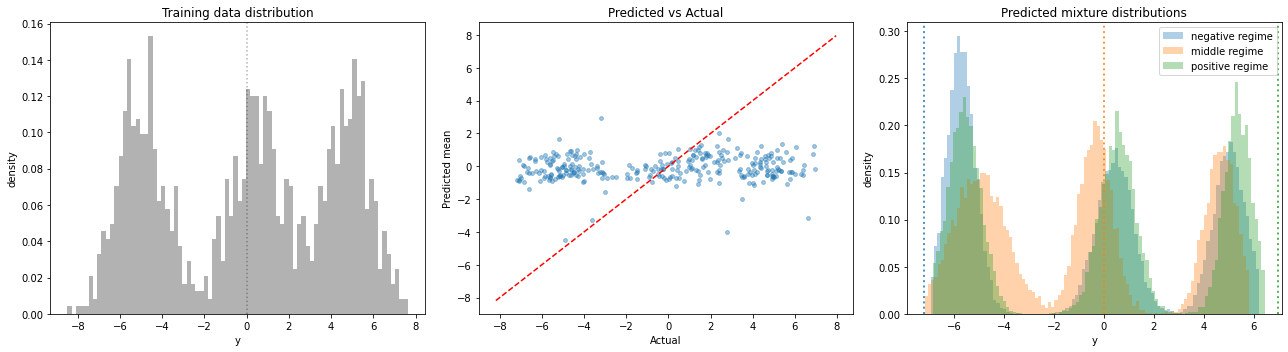

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Left: histogram of training data showing multimodality
ax = axes[0]
ax.hist(Y_train, bins=80, density=True, alpha=0.6, color="gray")
ax.set_xlabel("y")
ax.set_ylabel("density")
ax.set_title("Training data distribution")
ax.axvline(0, color="black", linestyle=":", alpha=0.3)

# Middle: predictions vs actuals
ax = axes[1]
ax.scatter(Y_test, Y_pred, alpha=0.4, s=15)
lims = [min(Y_test.min(), Y_pred.min()) - 1, max(Y_test.max(), Y_pred.max()) + 1]
ax.plot(lims, lims, "r--")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted mean")
ax.set_title("Predicted vs Actual")

# Right: predicted mixture density for 3 test samples
ax = axes[2]
# Pick samples from different regimes
neg_idx = np.argmin(Y_test)   # most negative
mid_idx = np.argmin(np.abs(Y_test))  # closest to 0
pos_idx = np.argmax(Y_test)   # most positive
idxs = [neg_idx, mid_idx, pos_idx]
labels = ["negative regime", "middle regime", "positive regime"]

for idx, label in zip(idxs, labels):
    s = dists[idx].sample(20000)
    lo, hi = np.percentile(s, [1, 99])
    ax.hist(s, bins=100, density=True, alpha=0.35, range=(lo, hi), label=label)
    ax.axvline(Y_test[idx], color=f"C{idxs.index(idx)}",
               linestyle=":", linewidth=2, alpha=0.8)

ax.set_xlabel("y")
ax.set_ylabel("density")
ax.set_title("Predicted mixture distributions")
ax.legend()

plt.tight_layout()
plt.show()

## Summary

Normal mixtures work identically to LogNormal mixtures, but with **unbounded Y**.
The factory automatically detects that the score expression's log-terms don't
contain `log(y)`, so it skips the positivity clamp on observations — negative
Y values pass through unchanged.

The only manual pieces needed for any mixture are:
- **`fit_fn`**: Smart initialization via quantile splitting
- **`sample_fn`**: Component selection + sampling logic

The factory handles score, all 8 gradients, and the 8x8 Fisher Information
automatically via logsumexp-stable evaluation.